<a href="https://colab.research.google.com/github/ANISHG-26/ELG6131-Dementia-EDA/blob/main/ELG_6131_Dementia_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Leave commented out if already done
# pip install Pillow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [2]:
IMAGE_SIZE = [176,208]        # input image dimensions                                              (176,208)
BATCH_SIZE = 5000
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters) [.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2]
layers_unlocked = True        # unlock the imported pre-training layers?                            False
lr = 0.01                     # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
EPOCHS = 50                   # number of epochs to run                                             50
#momentum = .9                # momentum of SGD                                                     .9
MODEL_DIR = "models/"

In [3]:
original_data_directory = "ELG6131-Dementia-Dataset/"

if not(os.path.exists(original_data_directory.split("/")[0])):
  !git clone https://github.com/ANISHG-26/ELG6131-Dementia-Dataset.git
os.chdir(original_data_directory)

Cloning into 'ELG6131-Dementia-Dataset'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 9 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 33.15 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!unzip MRI.zip
!mv Alzheimer_s\ Dataset/ dementia_dataset/
!ls -la

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem219.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem22.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem220.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem221.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem222.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem223.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem224.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem225.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem226.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem227.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [5]:
os.chdir("dementia_dataset")

In [6]:
# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="train/",target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last')
test_data_gen = test_dr.flow_from_directory(directory="test",target_size=IMAGE_SIZE,batch_size=BATCH_SIZE,
                                           shuffle = False) # test data should not be shuffle

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

In [8]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [9]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


In [10]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


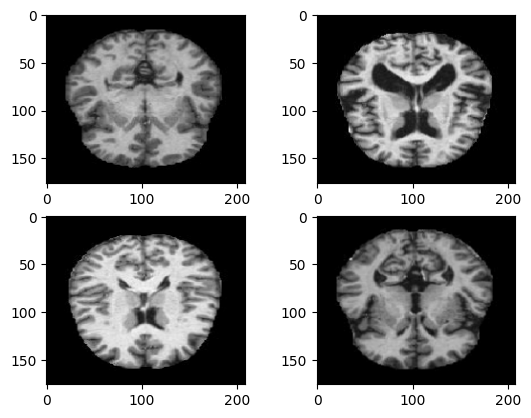

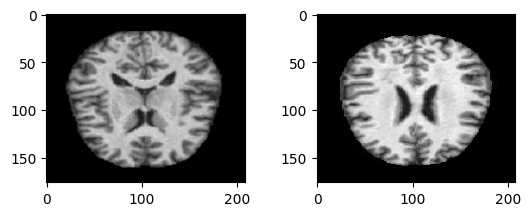

In [11]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [12]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


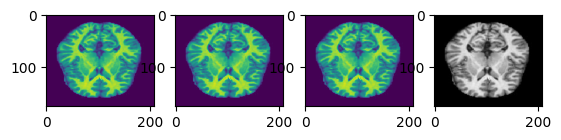

In [13]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [15]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model

In [17]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]


    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [18]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [19]:
model_history = model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=EPOCHS,batch_size=batch, shuffle=True)
#scores = model.evaluate(train_data, train_labels)
#print("Accuracy: %.2f%%" %(scores[-1]*100))

Epoch 1/50
220/220 [==============================] - 31s 65ms/step - loss: 1.5183 - accuracy: 0.7266 - precision: 0.4194 - recall: 0.2432 - auc: 0.6375 - val_loss: 1.2260 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6327
Epoch 2/50
220/220 [==============================] - 12s 56ms/step - loss: 1.1770 - accuracy: 0.7524 - precision: 0.5083 - recall: 0.2997 - auc: 0.7506 - val_loss: 1.0707 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7637
Epoch 3/50
220/220 [==============================] - 12s 55ms/step - loss: 1.0351 - accuracy: 0.7731 - precision: 0.5792 - recall: 0.3377 - auc: 0.7985 - val_loss: 1.2638 - val_accuracy: 0.7520 - val_precision: 0.5581 - val_recall: 0.0382 - val_auc: 0.6445
Epoch 4/50
220/220 [==============================] - 12s 56ms/step - loss: 0.9638 - accuracy: 0.7929 - precision: 0.6540 - recall: 0.3647 - auc: 0.8243 - val_loss: 0.9824 - val_accuracy: 0.7787 - val_precision

In [20]:
pred_labels = model.predict(test_data)

40/40 [==============================] - 2s 17ms/step


In [21]:
_ = model.evaluate(test_data, test_labels)

40/40 [==============================] - 1s 20ms/step - loss: 0.4465 - accuracy: 0.9305 - precision: 0.8619 - recall: 0.8599 - auc: 0.9714


In [22]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 104, 16)       0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

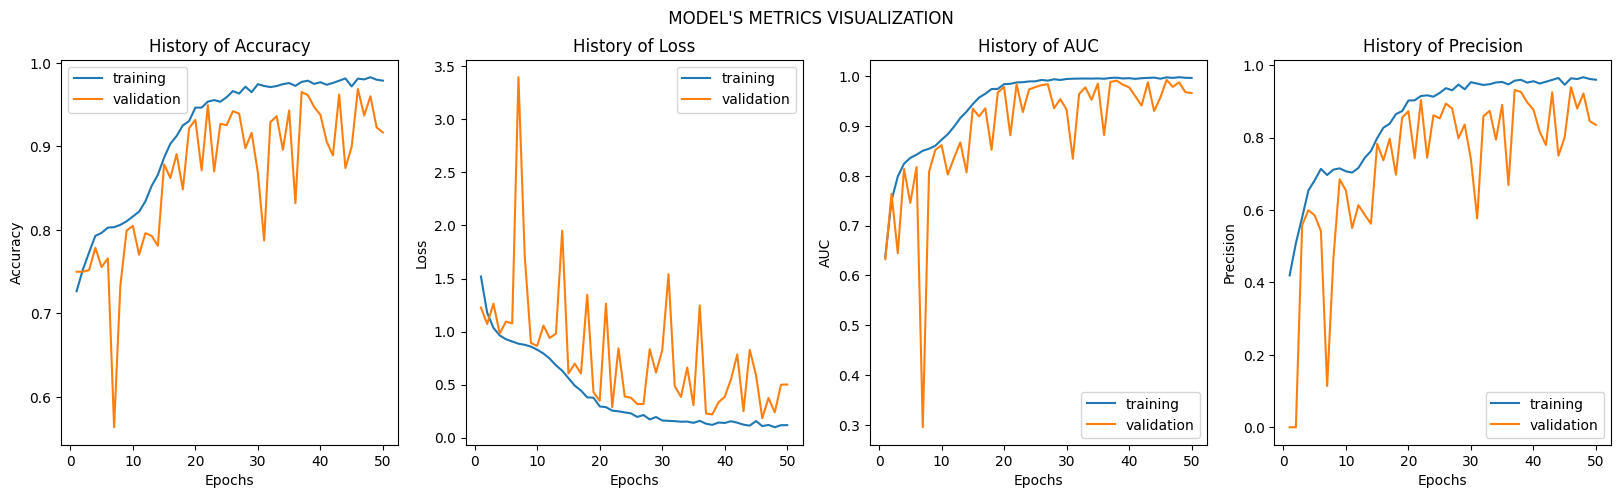

In [23]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'])

In [24]:
work_dir = '/content/ELG6131-Dementia-Dataset/'
model_save_path = os.path.join(work_dir, MODEL_DIR)
if not os.path.exists(model_save_path ):
  os.mkdir(model_save_path)
model.save(model_save_path + 'model.h5', save_format='h5')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 104, 16)       0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

In [25]:
CLASSES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

    MildDemented       0.99      0.80      0.88       190
ModerateDemented       1.00      0.80      0.89        10
     NonDemented       0.99      0.78      0.87       601
VeryMildDemented       0.73      0.99      0.84       455

       micro avg       0.86      0.86      0.86      1256
       macro avg       0.93      0.84      0.87      1256
    weighted avg       0.90      0.86      0.86      1256
     samples avg       0.86      0.86      0.86      1256



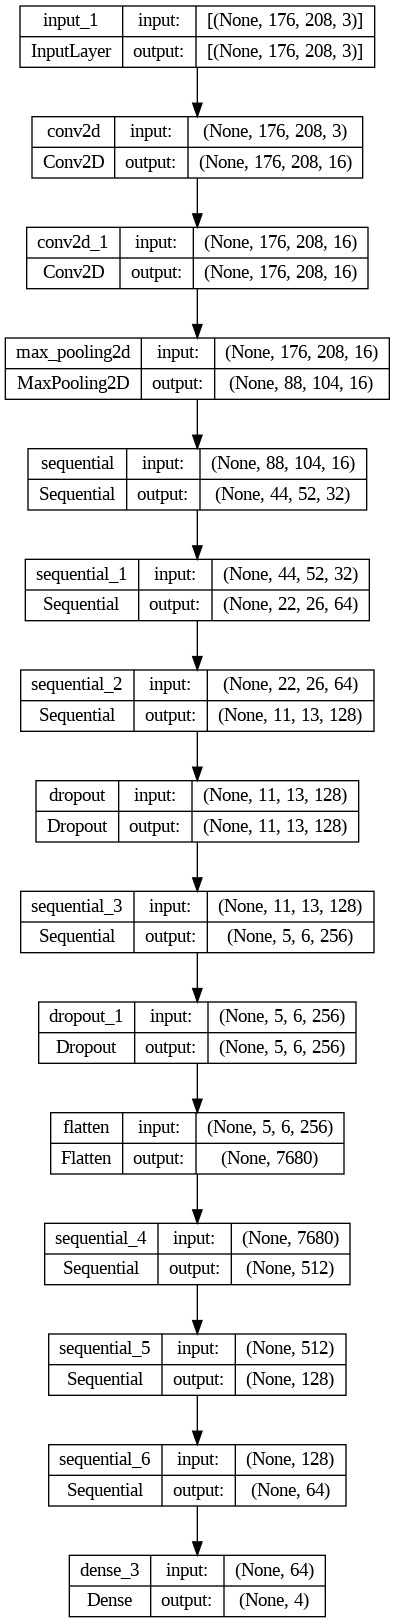

In [26]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

pretrained_model = load_model(model_save_path + "/model.h5")

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)